In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Our functions import

In [2]:
from generate_population_scripts import (generate_population,
                                         evaluate_distance_fitness, 
                                         evaluate_fitness_customers_count,
                                         evaluate_fitness_customers_served_demands,
                                         evaluate_fitness_vehicle_count,
                                         find_depot_using,
                                         get_evalution_count, 
                                         set_evaluation_count)
from combination import cut_and_crossfill, mutation_inverse, mutation_scramble
from selection import roulette_wheel, binary_tournament

In [3]:
def algorithm_run(pop_count, dataset, depot_location_dict, vehicle_count, selection_method, FITNESS_FUNCTION, MUTATION_METHOD, RECOMBINATION_METHOD, max_capacity=None, max_distance=None, p_m=0.1, p_c =0.9 ,max_evaluations = 5000, vehicle_depot_constraint=True, all_customers=True):
    """
    one constraint should be always given as input, the maximum capacity or maximum distance
    """
    ## reset the evaluation counts
    set_evaluation_count(0)

    population, fitness_pop = generate_population(max_capacity=max_capacity,
                                                     max_distance=max_distance,
                                                     depot_location_dict= depot_location_dict,
                                                     dataset=dataset, 
                                                     pop_count= pop_count,
                                                     vehicle_count= vehicle_count, 
                                                     fitness_function = FITNESS_FUNCTION, 
                                                     vehicle_depot_constraint = vehicle_depot_constraint,
                                                     all_customers=all_customers)
    generation_count = 0

    best_chromosome = None
    best_chromsome_fitness = None

    while get_evalution_count() < max_evaluations:
        print(f'Generation Count: {generation_count}, Evaluations number: {get_evalution_count()}')
        ## create pair of the parents
        parent_pairs = []
        for _ in range(pop_count):
            pair = selection_method(population, fitness_pop)
            parent_pairs.append(pair)

        
        offsprings = []
        fitness_offsprings = []
        for parents in parent_pairs:
            recombination_p = np.random.random()

            ## the offspring for this iteration
            iteration_offspring = []
            
            ######## Recombination ########
            if recombination_p < p_c:
                offspring1, offspring2 =  RECOMBINATION_METHOD(parents[0], parents[1], dataset, max_capacity, max_distance, depot_location_dict, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]

            
            ######## Mutation ########
            mutation_p = np.random.random()

            ## if cross over has happend
            if len(iteration_offspring) != 0 and mutation_p < p_m:
                offspring1 = MUTATION_METHOD(iteration_offspring[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(iteration_offspring[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if cross over had not happened
            elif mutation_p < p_m:
                offspring1 = MUTATION_METHOD(parents[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(parents[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if both cross over and mutation has not happened!
            else:
                iteration_offspring = [parents[0], parents[1]]
            
            ## finally append the genarated offsprings to offspring array 
            offsprings.append(iteration_offspring[0])
            offsprings.append(iteration_offspring[1])
            
            depot_symbol = find_depot_using(iteration_offspring[0], list(depot_location_dict.keys()))
            fitness_offsprings.append(FITNESS_FUNCTION(iteration_offspring[0], depot_location_dict[depot_symbol], dataset, depot_symbol))
            depot_symbol = find_depot_using(iteration_offspring[1], list(depot_location_dict.keys()))
            fitness_offsprings.append(FITNESS_FUNCTION(iteration_offspring[1], depot_location_dict[depot_symbol], dataset, depot_symbol))

        ## replace the old population with the new ones

        ## the whole generation: parents + offsprings
        generation_population = population.copy()
        generation_population.extend(offsprings)

        ## whole generation fitness: parents fitness + offsprings fitness
        generation_fitness = fitness_pop.copy()
        generation_fitness.extend(fitness_offsprings)

        ## the sorted generation
        generation_population_sorted = np.array(generation_population)[np.argsort(generation_fitness)]
        generation_fitness_sorted = np.sort(generation_fitness)

        ## Step 10
        ## extract the best of the new generation
        best_of_generation_population = generation_population_sorted[:pop_count]
        best_of_generation_fitness = generation_fitness_sorted[:pop_count]

        best_chromosome = generation_population_sorted[0]
        best_chromsome_fitness = generation_fitness_sorted[0]
        
        ## save them into the original population arrays
        population = best_of_generation_population.tolist()
        fitness_pop = best_of_generation_fitness.tolist()
        

        ## increase the generation value
        generation_count += 1
    
    return best_chromosome, best_chromsome_fitness

# PROBLEM No. 1
The goal is to minimize the distance gone, of the vehicles with the parameters below
- There is 1 depot in the location `(-14, 9)`
- There are `6` vehicles
- Maximum Capacity is `70`
- The locations of the customers and their demands are in `P1.txt` file
- The distance each vehicle can go is not limited.

In [6]:
p1_data = pd.read_csv('data/P1.txt', delimiter=' ')
DEPOT_LOCATION = (-14, 9)

In [7]:
problem1_best_chromsome, problem1_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=70, 
                vehicle_count=6, 
                max_distance=None,
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_distance_fitness,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=300)

problem1_best_chromsome, problem1_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(1)151132150102(1)140175186187163173(1)133160185191104119(1)129194179153(1)|(1)189164188111128(1)138135165101139184(1)174141(1)200124177172167(1)199183147108168121178(1)142118146107198130(1)|(1)156123105136152(1)169109161117(1)192193134(1)|(1)115127176159114144(1)|(1)149190113(1)|(1)195125154137157166(1)106145170155126182(1)110162103120148(1)|(1)122131143181158(1)112116171197180196(1)',
 6980)

In [6]:
def plot_result(vehicle_solution):
    plt.figure(figsize=(12,8))
    for vehicle_number, vehicle in enumerate(vehicle_solution.split('|')):
        locations_x_served = []
        locations_y_served = []
        for idx in range(3, len(vehicle) + 1, 3):
            symbol = vehicle[idx-3: idx]
            if symbol == '(1)':
                locations_x_served.append(DEPOT_LOCATION[0])
                locations_y_served.append(DEPOT_LOCATION[1])
            else:
                customer_num = (int(symbol) - 100)
                customer = p1_data[p1_data.number == customer_num]
                loc_x, loc_y = customer.x.values[0], customer.y.values[0]
                locations_x_served.append(loc_x)
                locations_y_served.append(loc_y)
                plt.text(loc_x, loc_y, s=f'{customer_num}')
        plt.plot(locations_x_served, locations_y_served, label=f'vehicle number:{vehicle_number}', marker='^', linestyle='--', alpha=0.5)


    plt.legend()
    plt.plot()

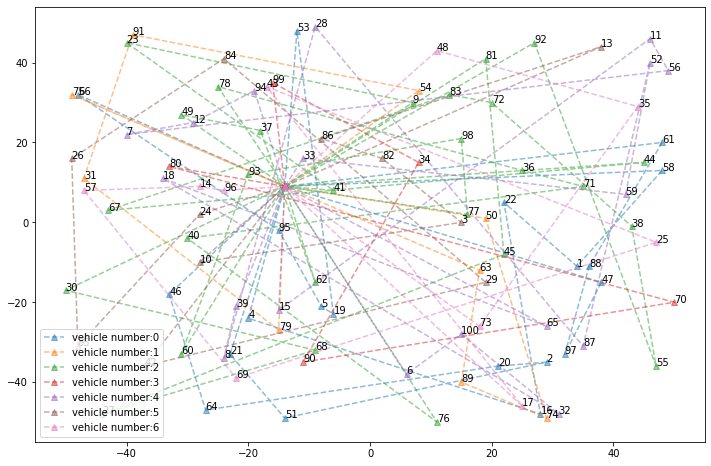

In [7]:
plot_result(problem1_best_chromsome)

# Problem No. 2
The goal is to maximize the customers recieved service with parametes below
- There is 1 depot in the location `(0, 13)`
- There are `4` vehicles
- Maximum distace each vehicle can go is `200` Km
- The locations of the customers and their demands are in `P2.txt` file
- The capacity is not limited for vehicles

In [9]:
p2_data = pd.read_csv('data/P2.txt', delimiter=' ')
DEPOT_LOCATION = (0, 13)

In [10]:
problem2_best_chromsome, problem2_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p2_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=None, 
                max_distance=200,
                vehicle_count=4, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=300, 
                all_customers=False)

problem2_best_chromsome, problem2_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(1)142168139118165198123158169133121180191160(1)|(1)138132163193129171181189155196156103(1)|(1)200175109(1)|(1)',
 0.034482758620689655)

In [23]:
problem2_best_chromsome.count('|')

3

In [11]:
## the number of customers served
1 / problem2_best_chromsome_fitness

29.0

# Problem No. 3
The goal is to maximize the demands of customers with parametes below
- There is 1 depot in the location `(-17, -4)`
- There are `4` vehicles
- Maximum distace each vehicle can go is `200` Km
- The locations of the customers and their demands are in `P3.txt` file
- The capacity is not limited for vehicles

In [12]:
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')
DEPOT_LOCATION = (-17, -4)

In [13]:
problem3_best_chromsome, problem3_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p3_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=None, 
                max_distance=200,
                vehicle_count=4, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_served_demands,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=300, 
                all_customers=False)

problem3_best_chromsome, problem3_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(1)111194184102167119186189113171132192128146164134101(1)|(1)179187168137107150(1)|(1)157198135144(1)|(1)154166190(1)',
 0.00030665440049064706)

In [14]:
## the maximum value of served demands 
1 / problem3_best_chromsome_fitness

3261.0

# Problem No. 4
The goal is to minimize number of vehicles with parametes below
- There is 1 depot in the location `(24, -7)`
- There are `?` vehicles (optimization objective)
- Maximum distace each vehicle can go is `200` Km
- The locations of the customers and their demands are in `P4.txt` file
- The capacity is not limited for vehicles

In [15]:
p4_data = pd.read_csv('data/P4.txt', delimiter=' ')
DEPOT_LOCATION = (24, -7)

In [16]:
problem4_best_chromsome, problem4_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p4_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_vehicle_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=300,
                all_customers=False)

problem4_best_chromsome, problem4_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(1)154198162136245147110205127220101199233217138149221201238142191113107173158171172225249106204182103244180212236241206183122210196116224218153228109177115(1)|(1)203214105143120185184207161239148192129170168187179194128119209174131159175229186188112104157130230222151240121197190167(1)|(1)227200146123248133195211202124114152242216126223181213169139125160250(1)|(1)237144165226164163231166178150189176215137232246118156134(1)|(1)234208243193132155219141235135140247111108117102145(1)|(1)',
 12.261666666666667)

In [17]:
## the vehicle count used
problem4_best_chromsome.count('|')

5

In [18]:
## the mean distance over the limit
(problem4_best_chromsome_fitness - int(problem4_best_chromsome_fitness)) * 200

52.33333333333334

# Problem No. 5
The goal is to minimize the distance gone, of the vehicles with the parameters below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- There are `11` vehicles
- Maximum Capacity is `100`
- The locations of the customers and their demands are in `P5.txt` file
- The distance each vehicle can go is not limited.

In [4]:
p5_data = pd.read_csv('data/P5.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    

In [5]:
problem5_best_chromsome, problem5_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p5_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=11, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_distance_fitness,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=300)

problem5_best_chromsome, problem5_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(3)168104216248155116115(3)|(3)181162130200195194228(3)|(3)125134208243232172(3)119218139129163203(3)|(3)226133157250237175138109(3)245246238177247223191180122(3)188235123(3)169142149192204107193153202(3)160164230221190136(3)|(3)196147110117126(3)132127148189212197131(3)|(3)144101240210209198158114217(3)|(3)176171(3)|(3)154182(3)|(3)234242219225121106206137201(3)227170146103224241(3)207159174183118113205135233(3)|(3)244222211179199(3)145187(3)249173186108229(3)|(3)102215143152184236166128151(3)156112141150167214(3)|(3)120140(3)185239165124213(3)105161220(3)231111(3)178(3)',
 10516)

# Problem No. 6
The goal is to maximize the customers recieved service with parametes below
- There are two depots in the location `(11, 36)`, `(19, -41)`
- There are `7` vehicles
- Maximum distace each vehicle can go is `250` Km
- The locations of the customers and their demands are in `P6.txt` file
- The capacity is not limited for vehicles

In [19]:
p6_data = pd.read_csv('data/P6.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (11, 36),
    '(2)': (19, -41)
}    

In [20]:
problem6_best_chromsome, problem6_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p6_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=250,
                vehicle_count=7, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=300, 
                all_customers=False)

problem6_best_chromsome, problem6_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(1)172101213127158188193166113111153207208131168171156105125110119(1)|(1)157186191117173165204185197184194195198141144183182212218(1)|(1)174121107196164211217122179103162(1)|(1)',
 0.0196078431372549)

In [21]:
1 / problem6_best_chromsome_fitness

51.0

# Problem No. 7
The goal is to maximize the demands of customers with parametes below
- There are three depots in the locations `(44, -41)`, `(-24, -8)`, `(-33, 30)`, `(10, 43)`
- There are `10` vehicles
- Maximum distace each vehicle can go is `250` Km
- The locations of the customers and their demands are in `P7.txt` file
- The capacity is not limited for vehicles

In [30]:
p7_data = pd.read_csv('data/P7.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (44, -41),
    '(2)': (-24, -8),
    '(3)': (-33, 30),
    '(4)': (10, 43)
}

In [31]:
problem7_best_chromsome, problem7_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p7_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=250,
                vehicle_count=10, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_served_demands,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=300,
                all_customers=False)

problem7_best_chromsome, problem7_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(2)232290209279298180246294254203156105143118280112219213261125165124173108288289182258274120239(2)|(2)177292123208238169264151237160185276179204137217253128126167127284244139178145190(2)|(2)271218113226144200215265162(2)|(2)248199152142129(2)|(2)',
 0.00013395847287340923)

In [32]:
1 / problem7_best_chromsome_fitness

7465.000000000001

# Problem No. 8
Is same as problem 4, but having multiple depot

In [4]:
p8_data = pd.read_csv('data/P8.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (8, 17),
    '(2)': (31, -42),
    '(3)': (-6, -22),
    '(4)': (15, -10),
    '(5)': (-27, 43)
}

In [10]:
problem8_best_chromsome, problem8_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p8_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_vehicle_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=500)

problem8_best_chromsome, problem8_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450


('(1)213109192200189178125133186163116161211129159184187104139136101137205135173122214169(1)|(1)181107131112118143132208218164140191158207151120124204154197190138119220108(1)|(1)128174216202219148147160149145180199206155103105175142123177117156203(1)|(1)121209179152176153182212141201195194167144126217146130102210113170168(1)|(1)172183198114215127111110134171165150196193115162(1)|(1)157185106166188(1)|(1)',
 11.280000000000001)

In [11]:
## the vehicle count used
problem8_best_chromsome.count('|')

6

In [12]:
## the mean distance over the limit
(problem8_best_chromsome_fitness - int(problem8_best_chromsome_fitness)) * 200

56.00000000000023

# Problem No. 9
The goal is to minimum the distance gone as the Problems 2 and 5 but the difference is that the vehicle can go and back to another depot, and start from that depot! 

In [4]:
p9_data = pd.read_csv('data/P9.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (8, 17),
    '(2)': (31, -42),
    '(3)': (-6, -22),
    '(4)': (15, -10),
    '(5)': (-27, 43)
}    

In [5]:
problem9_best_chromsome, problem9_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p9_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=11, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_distance_fitness,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000, 
                vehicle_depot_constraint=False)

problem9_best_chromsome, problem9_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250


('(1)172126124156177175133140180(1)|(1)108116167136178101155119107120168(1)|(1)130173117153134148(1)|(1)169(1)|(1)146154121106(1)|(1)114161131179152105139151163(1)|(1)142145104129135176149(1)|(1)165150137110123(1)|(1)171(1)|',
 3476)

# Problem No. 10